# Assignment 3: Attention

The objectives of this assignment are:

+ To implement Bahdanau Attention and Luong General Attention classes.
+ To do a comparative (# of steps to converge, test error) of the three methods we have seen. Use these values for the comparative (the training datset size and `rnn_units` and `batch_size` values are up to you): 
    + `n_timesteps_in = 100`
    + `n_features = 20`.   
+ To implement a function to visualize the attention weights for one example. You can visualize them as in this figure (that corresponds to a machine translation task):

<div>
<center>
<img src="https://jalammar.github.io/images/attention_sentence.png" width="200">
</center>
</div>

+ To write a blog entry explaining in your words how does attention work. You can do it in your favourite blog site. If you do not have a favourite blog site, you can start one here: https://hackmd.io/

You have to report all your work at the end of this notebook.



# Code

In [3]:
#@title Some utils
from random import randint
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

def generate_sequence(length, n_unique):
    """
    Generate a sequence of random integers.
    
    :length: Total length of the generated sequence
    :n_unique: Maximum number allowed
    """
    return [randint(1, n_unique-1) for _ in range(length)]

def one_hot_encode(sequence, n_unique):
    """
    Transform a sequence of integers into a one-hot-encoding vector
    
    :sequence: The sequence we want to transform
    :n_unique: Maximum number allowed (length of the one-hot-encoded vector)
    """
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

def one_hot_decode(encoded_seq):
    """
    Transorm a one-hot-encoded vector into a list of integers
    
    :encoded_seq: One hot encoded sequence to be transformed
    """
    return [np.argmax(vector) for vector in encoded_seq]


def get_reversed_pairs(time_steps,vocabulary_size):
    """
    Generate a pair X, y where y is the 'reversed' version of X.
    
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    # generate random sequence and reverse it
    sequence_in = generate_sequence(time_steps, vocabulary_size)
    sequence_out = sequence_in[::-1]

    # one hot encode both sequences
    X = one_hot_encode(sequence_in, vocabulary_size)
    y = one_hot_encode(sequence_out, vocabulary_size)
    
    # reshape as 3D so it can be inputed to the LSTM
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))
    return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size):
    """
    Generates a datset of reversed pairs X, y.
    
    :train_size: Number of train pairs
    :test_size: Number of test pairs
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    
    # Generate reversed pairs for training
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
    pairs= np.array(pairs).squeeze()
    X_train = pairs[:,0]
    y_train = pairs[:,1]
    
    # Generate reversed pairs for test
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
    pairs= np.array(pairs).squeeze()
    X_test = pairs[:,0]
    y_test = pairs[:,1]	

    return X_train, y_train, X_test, y_test


def train_test(model, X_train, y_train , X_test, y_test, epochs=500, batch_size=32, patience=5):
    """
    It trains a model and evaluates the result on the test dataset
    
    :model: Model to be fit
    :X_train, y_train: Train samples and labels 
    :X_test y_test: Test samples and labels 
    :epochs: Maximum number of iterations that the model will perform
    :batch_size: Samples per batch
    :patience: Number of rounds without improvement that the model can perform. If there is no improvement on the loss, it will stop the trainning process.
    """
    
    # Train the model
    history=model.fit(X_train, y_train, 
                      validation_split= 0.1, 
                      epochs=epochs,
                      batch_size=batch_size, 
                      callbacks=[EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)])
    
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)
    
    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
    
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    # summarize history for loss
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title(model.name+' loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')
    
    # summarize history for accuracy
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title(model.name+' accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
def predict(model, n_timesteps_in,n_features, x, y_real=None, ):
    pred=model.predict(x.reshape(1,n_timesteps_in,n_features), batch_size=1)
    print('input', one_hot_decode(x))    
    print('predicted', one_hot_decode(pred[0]))
    if y_real is not None:
        print('expected', one_hot_decode(y_real))
        
### Visualization functions

def get_weights(seq_in, attention, encoder_lstm, decoder_lstm, decoder_dense):
    """Generates the attention weights and plots them.

    Args:
    - seq_in: numpy array of shape (batch_size, n_timesteps_in, n_features). Input sequence to the model.
    - attention: attention layer object.
    - encoder_lstm: LSTM layer object. Encoder part of the model.
    - decoder_lstm: LSTM layer object. Decoder part of the model.
    - decoder_dense: Dense layer object. Decoder part of the model.

    Returns:
    - seq_in: numpy array of shape (batch_size, n_timesteps_in, n_features). Same as input.
    - seq_out: numpy array of shape (batch_size, n_timesteps_out, n_features). Output sequence of the model.
    - attention_plot: numpy array of shape (batch_size, n_timesteps_in, n_timesteps_in). Attention weights.

    """
    attention_plot = np.zeros((batch_size, n_timesteps_in, n_timesteps_in))
    # Convert seq_in to a tensor
    encoder_inputs = tf.convert_to_tensor(seq_in, dtype=tf.float64)
    # Compute encoder outputs and hidden state
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
    states = [state_h, state_c]
    all_outputs = []
    # Initialize decoder inputs as a tensor with zeros
    decoder_input_data = np.zeros((batch_size, 1, n_features))
    # Set first input as the start symbol
    decoder_input_data[:, 0, 0] = 1 
    inputs = decoder_input_data
    # Initialize decoder hidden state as encoder hidden state
    decoder_outputs = state_h
    # Iterate over all input timesteps
    for t in range(n_timesteps_in):
        # Compute attention weights
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        # Reshape attention weights to (batch_size, n_timesteps_in)
        attention_weights = tf.reshape(attention_weights, (batch_size, n_timesteps_in))
        # Store attention weights in attention plot
        attention_plot[:, t, :] = attention_weights
        decoder_outputs=tf.expand_dims(decoder_outputs, 1)
        context_vector = tf.expand_dims(context_vector, 1)
        inputs = tf.concat([context_vector, inputs], axis=-1)
        decoder_outputs, state_h, state_c = decoder_lstm(inputs,
                                              initial_state=states)    
        outputs = decoder_dense(decoder_outputs)
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)
        inputs = outputs
        states = [state_h, state_c]
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    seq_out=one_hot_decode(decoder_outputs[0])

    return seq_in, seq_out, attention_plot

def plot_attention(attention_plot, sequence, predicted_sequence):
    """
    Args:
    attention_plot: numpy array of shape (batch_size, n_timesteps_in, n_timesteps_in).
        Attention weights for each time step of the decoder.
    sequence: list of length batch_size.
        One-hot encoded input sequences.
    predicted_sequence: list of length batch_size.
        Predicted output sequences.

    Returns:
    None
    """
    print(attention_plot.shape)
    # Create a figure and subplot
    fig = plt.figure(figsize=(19,19))
    ax = fig.add_subplot(1, 1, 1)

    # Plot the attention weights as a heatmap
    ax.matshow(attention_plot[0], cmap='viridis')

    # Set the x-axis and y-axis labels
    fontdict = {'fontsize': 10}
    ax.set_xticklabels([''] + one_hot_decode(sequence[0]), fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sequence, fontdict=fontdict)

    # Set the tick marks for the x-axis and y-axis
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Show the plot
    plt.show()

In [4]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

#attention model
def build_attention_model(attention, batch_size, rnn_units):
    
    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
    
    states = [encoder_state_h, encoder_state_c]
    
    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')
    
    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))
    
    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h
    
    # Decoder will only process one time step at a time.
    for _ in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)

        # create the context vector by applying attention to 
        # Concatenate the input + context vectore to find the next decoder's input
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)        
        outputs = decoder_dense(decoder_outputs)
        
        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)
        
        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]
        
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model, encoder_lstm, decoder_lstm, decoder_dense


class LuongDotAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(LuongDotAttention, self).__init__()

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis, 
                                       values_transposed), perm=[0, 2, 1])

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights



In [5]:
# dataset 
n_timesteps_in = 100  # Sequence length
n_features = 20     # Maximum number allowed-1 (length of the one-hot-encoded vector)
train_size = 2000 
test_size = 200
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features )

# training parameters
batch_size = 100

# model parameters
rnn_units = 100

Epoch 1/200
18/18 [==============================] - 141s 2s/step - loss: 2.9670 - accuracy: 0.0526 - val_loss: 2.9471 - val_accuracy: 0.0508
Epoch 2/200
18/18 [==============================] - 3s 188ms/step - loss: 2.9456 - accuracy: 0.0547 - val_loss: 2.9435 - val_accuracy: 0.0532
Epoch 3/200
18/18 [==============================] - 3s 173ms/step - loss: 2.9422 - accuracy: 0.0602 - val_loss: 2.9385 - val_accuracy: 0.0684
Epoch 4/200
18/18 [==============================] - 3s 170ms/step - loss: 2.9357 - accuracy: 0.0682 - val_loss: 2.9301 - val_accuracy: 0.0756
Epoch 5/200
18/18 [==============================] - 3s 172ms/step - loss: 2.9255 - accuracy: 0.0769 - val_loss: 2.9218 - val_accuracy: 0.0774
Epoch 6/200
18/18 [==============================] - 3s 181ms/step - loss: 2.9164 - accuracy: 0.0813 - val_loss: 2.9127 - val_accuracy: 0.0833
Epoch 7/200
18/18 [==============================] - 3s 171ms/step - loss: 2.9081 - accuracy: 0.0853 - val_loss: 2.9054 - val_accuracy: 0.0854


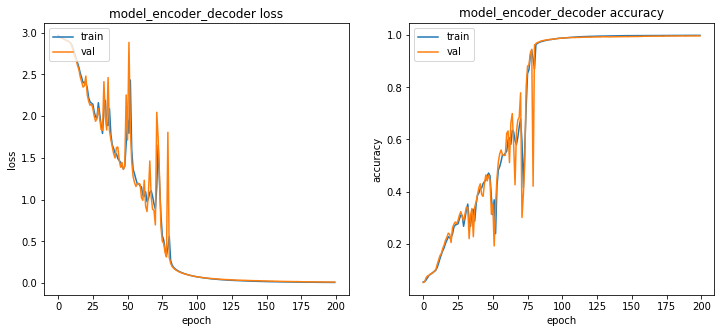

In [7]:
### Luong Attention
attention_luong = LuongDotAttention()
model_attention_luong, encoder_lstm_luong, decoder_lstm_luong, decoder_dense_luong = build_attention_model(attention_luong, batch_size, rnn_units)
train_test(model_attention_luong, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=200, patience=25)

In [8]:
class BahdanauAttention(tf.keras.layers.Layer):
    
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.units = units
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query shape: (batch_size, hidden_size)
        # query_with_time_axis shape: (batch_size, 1, hidden_size)
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape: (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape: (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape: (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights
    
    def get_config(self):
        config = super().get_config()
        config.update({'units': self.units})
        return config

In [9]:
class LuongGeneralAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongGeneralAttention, self).__init__()
        # Only a weight matrix is needed
        self.W = tf.keras.layers.Dense(units)
        self.units = units


    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # Compute the attention scores using the query and the values
        attention_scores = self.W(query_with_time_axis + values_transposed)

        # Apply a softmax function to the attention scores to obtain the attention weights
        attention_weights = tf.nn.softmax(attention_scores, axis=1)

        # Multiply the attention weights by the values to obtain the context vector
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

    def get_config(self):
        config = super().get_config()
        config.update({'units': self.units})
        return config

Epoch 1/200
18/18 [==============================] - 142s 2s/step - loss: 2.9662 - accuracy: 0.0551 - val_loss: 2.9483 - val_accuracy: 0.0621
Epoch 2/200
18/18 [==============================] - 5s 281ms/step - loss: 2.9442 - accuracy: 0.0595 - val_loss: 2.9415 - val_accuracy: 0.0595
Epoch 3/200
18/18 [==============================] - 5s 282ms/step - loss: 2.9373 - accuracy: 0.0670 - val_loss: 2.9349 - val_accuracy: 0.0650
Epoch 4/200
18/18 [==============================] - 5s 276ms/step - loss: 2.9300 - accuracy: 0.0721 - val_loss: 2.9254 - val_accuracy: 0.0730
Epoch 5/200
18/18 [==============================] - 5s 282ms/step - loss: 2.9238 - accuracy: 0.0762 - val_loss: 2.9204 - val_accuracy: 0.0785
Epoch 6/200
18/18 [==============================] - 5s 276ms/step - loss: 2.9182 - accuracy: 0.0806 - val_loss: 2.9167 - val_accuracy: 0.0815
Epoch 7/200
18/18 [==============================] - 5s 274ms/step - loss: 2.9103 - accuracy: 0.0835 - val_loss: 2.9096 - val_accuracy: 0.0844


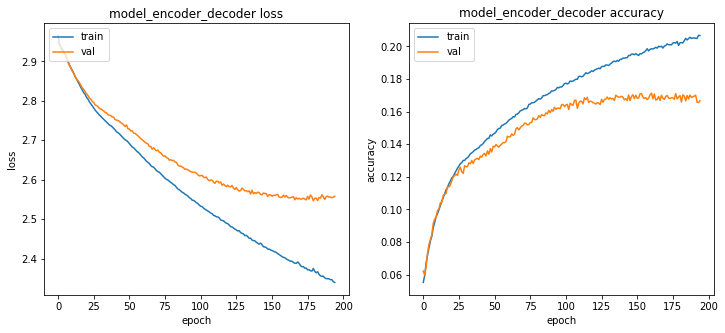

In [10]:
### Luong General Attention
batch_size=100
attention_luong_general = LuongGeneralAttention(rnn_units)
model_attention_luong_g, encoder_lstm_luong_g, decoder_lstm_luong_g, decoder_dense_luong_g = build_attention_model(attention_luong_general, batch_size, rnn_units)
train_test(model_attention_luong_g, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=200, patience=15)

Epoch 1/200
18/18 [==============================] - 150s 2s/step - loss: 2.9640 - accuracy: 0.0546 - val_loss: 2.9461 - val_accuracy: 0.0545
Epoch 2/200
18/18 [==============================] - 5s 252ms/step - loss: 2.9453 - accuracy: 0.0555 - val_loss: 2.9435 - val_accuracy: 0.0651
Epoch 3/200
18/18 [==============================] - 4s 249ms/step - loss: 2.9412 - accuracy: 0.0603 - val_loss: 2.9384 - val_accuracy: 0.0672
Epoch 4/200
18/18 [==============================] - 5s 252ms/step - loss: 2.9337 - accuracy: 0.0717 - val_loss: 2.9279 - val_accuracy: 0.0780
Epoch 5/200
18/18 [==============================] - 4s 241ms/step - loss: 2.9232 - accuracy: 0.0789 - val_loss: 2.9173 - val_accuracy: 0.0820
Epoch 6/200
18/18 [==============================] - 4s 245ms/step - loss: 2.9118 - accuracy: 0.0842 - val_loss: 2.9070 - val_accuracy: 0.0864
Epoch 7/200
18/18 [==============================] - 4s 240ms/step - loss: 2.9018 - accuracy: 0.0881 - val_loss: 2.8988 - val_accuracy: 0.0902


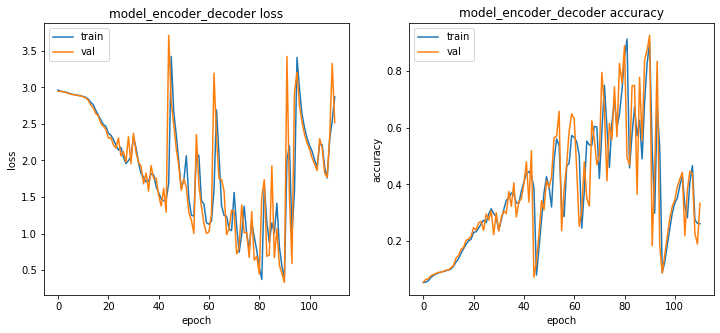

In [11]:
### Bahdanau Attention
attention_bahdanau = BahdanauAttention(rnn_units)
model_attention_bahd, encoder_lstm_bahd, decoder_lstm_bahd, decoder_dense_bahd = build_attention_model(attention_bahdanau, batch_size, rnn_units)
train_test(model_attention_bahd, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=200, patience=20)

## Visualization of Weights 

### Luong Dot Attention 

(100, 100, 100)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:217: UserWarning: FixedFormatter should only be used together with FixedLocator


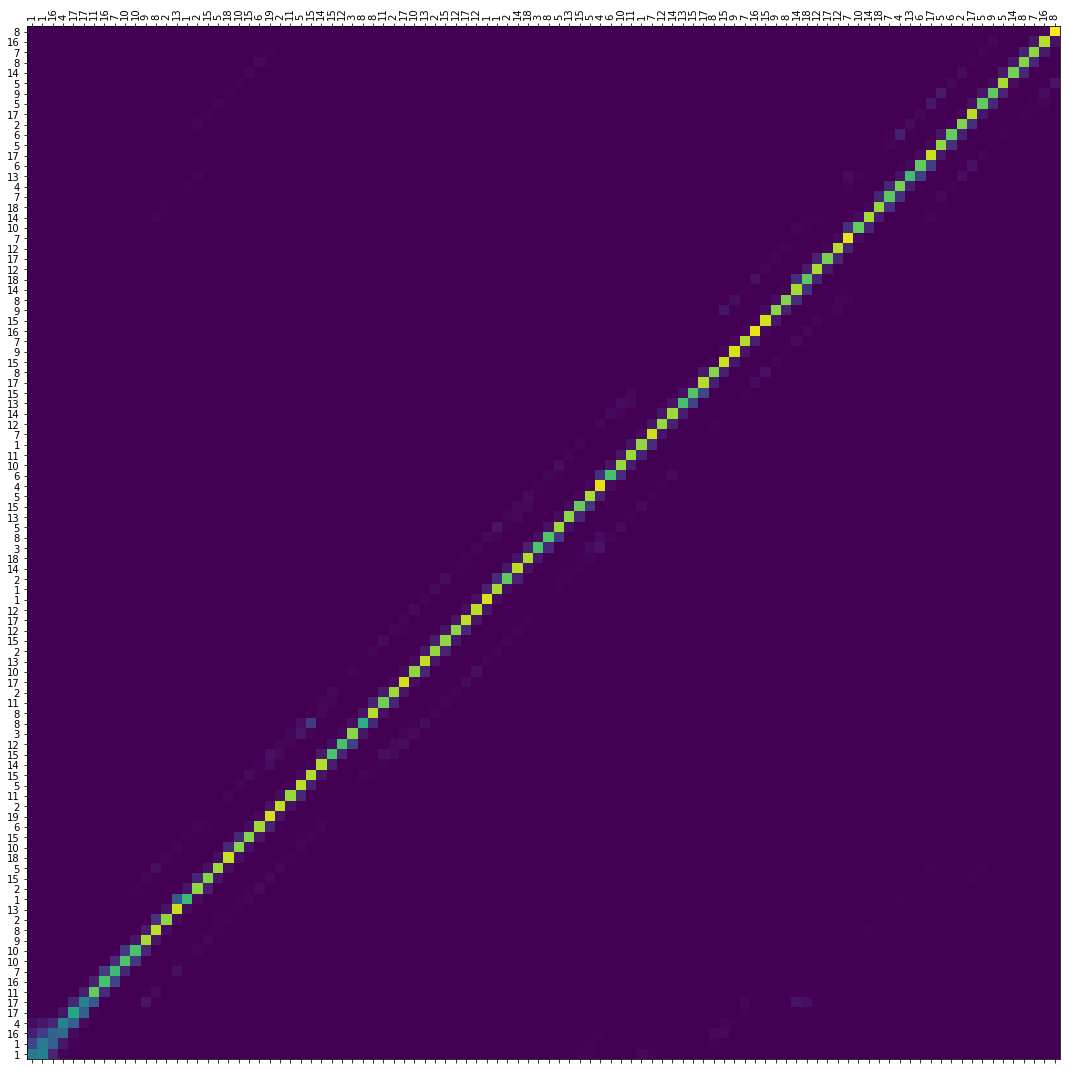

In [13]:
X_batch = X_test[:batch_size]
y_real = y_test[:batch_size]

seq_in, seq_out, attention_plot = get_weights(X_batch, attention_luong, encoder_lstm_luong, decoder_lstm_luong, decoder_dense_luong)
attention_plot = attention_plot[:len(seq_out), :len(one_hot_decode(seq_in[0]))]
plot_attention(attention_plot, seq_in, seq_out)

### Luong General Attention

(100, 100, 100)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:217: UserWarning: FixedFormatter should only be used together with FixedLocator


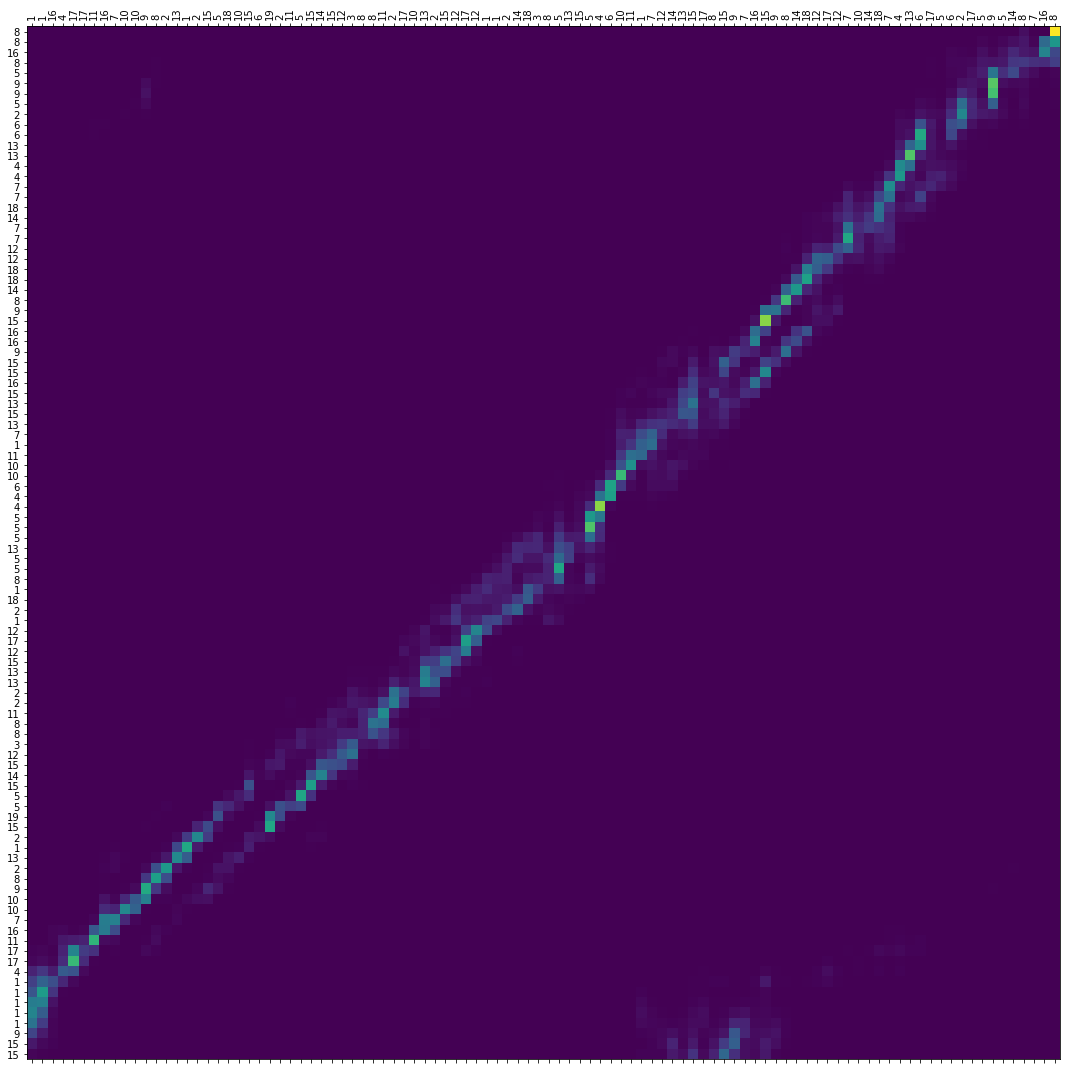

In [55]:
X_batch = X_test[:batch_size]
y_real = y_test[:batch_size]

seq_in, seq_out, attention_plot = get_weights(X_batch, attention_luong_general, encoder_lstm_luong_g, decoder_lstm_luong_g, decoder_dense_luong_g)
attention_plot = attention_plot[:len(seq_out), :len(one_hot_decode(seq_in[0]))]
plot_attention(attention_plot, seq_in, seq_out)

### Bahdanau Attention

(100, 100, 100)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:217: UserWarning: FixedFormatter should only be used together with FixedLocator


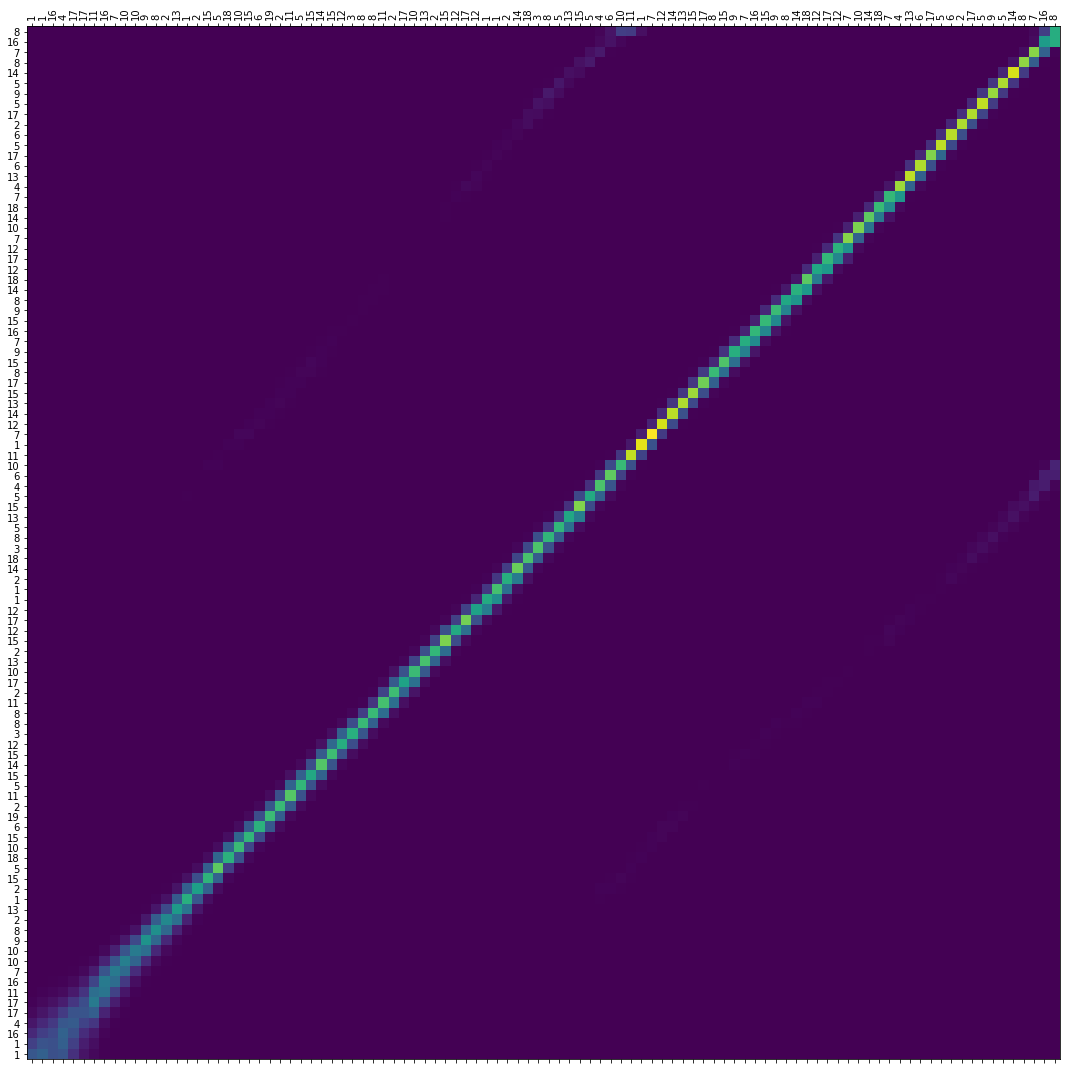

In [50]:
X_batch = X_test[:batch_size]
y_real = y_test[:batch_size]

# predict(model_attention, n_timesteps_in,n_features, X_batch, y_real, batch_size)
seq_in, seq_cut, attention_plot = get_weights(X_batch, attention_bahdanau, encoder_lstm_bahd, decoder_lstm_bahd, decoder_dense_bahd)
attention_plot = attention_plot[:len(seq_out), :len(one_hot_decode(seq_in[0]))]
plot_attention(attention_plot, seq_in, seq_out)

## Comparative

Interesting results we had. First of all, the Luong Dot Attention it was trained during 200 epochs with Early Stopping. We can see in the plots how the Loss decays rapidly, although it does it in a bumpy way with a lot of spikes - something that is repeated in the Bahdanau. Yet, the best results came from this Attention with an accuracy of >90%.

The Luong General Attention is not able to find an optimal solution an it seems it got stuck in a local minima, thus it is clearly converging but with a high loss and a low a accuracy. 

On the other hand, the Bahdanau got better results than the General Attention. As it is explained in the blog post, this mechanism is more complex than the Luong, and although it can be slower it usually gives you better results. Therefore, it is more suited for long sentences or sequence of words, because of the use of a NN to compute the weights.

Regarding to the visualization of the weights, we can see how the best models in terms of accuracy also have the neatest plots, with a visual structure to follow, while the one with worse results has more difficulties to focus on what it should focus, it got distracted on another things which were not as useful.

## Blog Post

https://hackmd.io/@goodjorx/dl-attention

# Report

+ Bahdanau Attention and Luong General Attention implementation.
+ Comparative.
+ Weight visualization. 
+ Blog site.

